In [1]:
import torch
import torchvision
import torchvision.transforms
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


 ship   cat truck   car


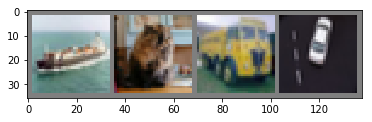

In [11]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [7]:
class Covnet( torch.nn.Module ):
    def __init__(self):
        super().__init__()
        conv1 = torch.nn.Conv2d(3,  10,  3)
        conv2 = torch.nn.Conv2d(10, 20,  3)
        conv3 = torch.nn.Conv2d(20, 30, 3)

        self.feat= torch.nn.Sequential(
            
                        conv1,
                        torch.nn.ReLU(),
                        torch.nn.MaxPool2d(2),
                        
                        conv2,
                        torch.nn.ReLU(),
                        torch.nn.MaxPool2d(2),
                        
                        conv3,
                        torch.nn.ReLU(),
                        torch.nn.MaxPool2d(2)
                       )
        
        self.linOut1 = torch.nn.Linear(30,10)
        
    def forward(self, x ):
        bs=x.shape[0]
        x = self.feat(x).view(bs,30,-1)
        x = torch.mean(x,-1)
        x = self.linOut1(x)
        return x
        

myNet = Covnet()

In [8]:
opt = torch.optim.SGD(myNet.parameters(), lr=0.001, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()


for e in range(2):
    running_loss = 0.0
    counts = 0
    for i,(img,y) in enumerate(trainloader):
        y_pred = myNet(img)
        loss = criterion(y_pred, y)
        loss.backward()
        opt.step()
        myNet.zero_grad()
        
        running_loss += loss.data.numpy()
        counts += img.shape[0]
        
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %(e + 1, i + 1, running_loss / counts))
            
    print("Epoch {}: ".format(e+1),running_loss/counts)

[1,  2000] loss: 0.559
[1,  4000] loss: 0.530
[1,  6000] loss: 0.510
[1,  8000] loss: 0.492
[1, 10000] loss: 0.477
[1, 12000] loss: 0.464
Epoch 1:  0.46131865735888483
[2,  2000] loss: 0.385
[2,  4000] loss: 0.380
[2,  6000] loss: 0.378
[2,  8000] loss: 0.374
[2, 10000] loss: 0.371
[2, 12000] loss: 0.367
Epoch 2:  0.36669046215087175


In [9]:
myNet = myNet.eval()

preds=[]
true =[]

for i,(img,y) in enumerate(testloader):
    y_pred = myNet(img)
    pred = torch.argmax(torch.nn.functional.softmax(y_pred, dim=-1),-1)
    preds.append(pred)
    true.append(y)
    
true, preds = torch.cat(true), torch.cat(preds)

  cat   dog   car horse
  cat   dog   dog horse


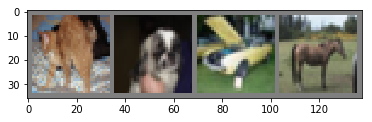

In [12]:
# show images
imshow(torchvision.utils.make_grid(img))
# print labels
print(' '.join('%5s' % classes[y[j]] for j in range(4)))
print(' '.join('%5s' % classes[pred[j]] for j in range(4)))

In [16]:
import sklearn.metrics

for i in range(10):
    msk = true==i
    s = sklearn.metrics.accuracy_score(true[msk],preds[msk])
    if i == 0: print('accuracy_score')
    print('{}: {}'.format(classes[i],s) )

accuracy_score
plane: 0.555
car: 0.627
bird: 0.269
cat: 0.389
deer: 0.151
dog: 0.483
frog: 0.874
horse: 0.436
ship: 0.56
truck: 0.609
